## CNN + 가격

In [2]:
pip install pyts

   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------- ----------- 1.8/2.5 MB 9.1 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 8.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
###  "시가": "Open", "고가": "High", "저가": "Low",,  "종가": "Adj Close", "거래량": "Volume"

C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0609 - mae: 0.1903 - val_loss: 0.0356 - val_mae: 0.1725
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0192 - mae: 0.1076 - val_loss: 0.0350 - val_mae: 0.1712
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0154 - mae: 0.0988 - val_loss: 0.0429 - val_mae: 0.1941
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0137 - mae: 0.0946 - val_loss: 0.0247 - val_mae: 0.1399
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0133 - mae: 0.0911 - val_loss: 0.0229 - val_mae: 0.1336
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0125 - mae: 0.0900 - val_loss: 0.0228 - val_mae: 0.1337
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0110 - mae: 0.0847 - val_loss: 0.0177 - val_mae: 0.1143
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0120 - mae: 0.0860 - val_loss: 0.0139 - val_mae: 0.0983
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.011

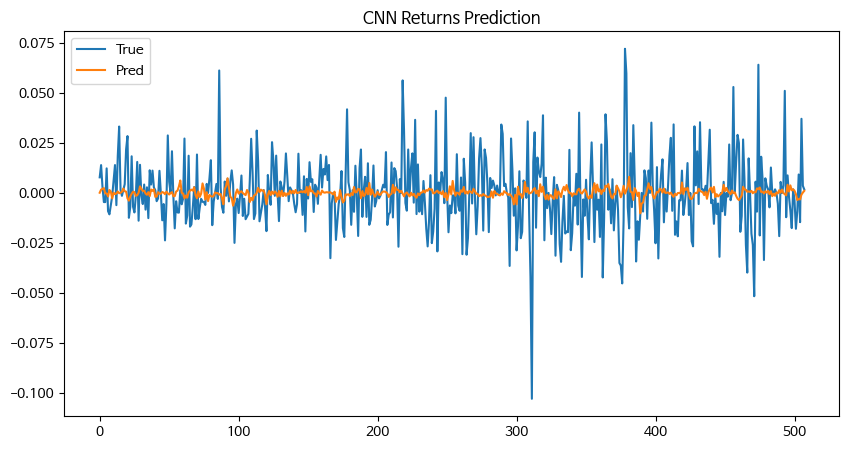

In [10]:
import numpy as np
import pandas as pd
import sys
import time
from pykrx import stock
from pyts.image import GramianAngularField
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 설정
ticker = '005930'        # 삼성전자의 KRX 티커 코드
start_date = '20150101'    # YYYYMMDD 형식
end_date = '20250601'
window_size = 20           # GAF 변환에 사용할 창 크기
image_size = window_size   # image_size를 window_size로 설정 (<= window_size)


def download_data_pykrx(ticker, start, end):
    """PyKrX를 이용해 KRX 주가(OHLCV) 데이터를 가져옵니다."""
    try:
        df = stock.get_market_ohlcv_by_date(start, end, ticker)
        if df.empty:
            raise ValueError("PyKrX: 반환된 데이터프레임이 비어 있습니다.")
        # 컬럼명을 pandas 스타일로 변환
        df.rename(columns={
            "시가": "Open", "고가": "High", "저가": "Low",
            "종가": "Adj Close", "거래량": "Volume"
        }, inplace=True)
        return df
    except Exception as e:
        print(f"PyKrX 데이터 다운로드 실패: {e}", file=sys.stderr)
        sys.exit(1)

# 1. 데이터 불러오기 및 수익률 계산
df = download_data_pykrx(ticker, start_date, end_date)
df['Return'] = df['Adj Close'].pct_change().fillna(0)
returns = df['Return'].values

# 충분한 데이터 확인
if len(returns) <= window_size + 1:
    print(f"데이터가 부족합니다. window_size({window_size}) 이상 필요", file=sys.stderr)
    sys.exit(1)

# 2. 슬라이딩 윈도우로 이미지 생성
def create_rolling_images(returns, window_size=20, image_size=20):
    # image_size는 window_size 이하여야 함
    gaf = GramianAngularField(image_size=image_size, method='summation')
    X, y = [], []
    for i in range(window_size, len(returns) - 1):
        window = returns[i-window_size:i].reshape(1, -1)
        img = gaf.fit_transform(window)[0]
        X.append(img)
        y.append(returns[i+1])
    X = np.array(X).reshape(-1, image_size, image_size, 1)
    return X, np.array(y)

X, y = create_rolling_images(returns, window_size, image_size)

# 3. 데이터 정규화 및 분할
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, shuffle=False)

# 4. CNN 모델 정의
def build_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)), Dropout(0.25),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)), Dropout(0.25),
        Flatten(), Dense(128, activation='relu'), Dropout(0.5),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# 5. 학습 및 평가
def train_and_evaluate():
    model = build_cnn((image_size, image_size, 1))
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[es]
    )
    loss, mae = model.evaluate(X_test, y_test)
    print(f"Test MSE: {loss:.6f}, MAE: {mae:.6f}")
    y_pred = scaler.inverse_transform(model.predict(X_test))
    y_true = scaler.inverse_transform(y_test.reshape(-1,1))
    plt.figure(figsize=(10,5))
    plt.plot(y_true, label='True')
    plt.plot(y_pred, label='Pred')
    plt.legend()
    plt.title('CNN Returns Prediction')
    plt.show()

if __name__ == '__main__':
    train_and_evaluate()


## 2025년7월30일까지 가격 예측

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# 데이터셋 로딩
dataset = datasets.ImageFolder(root='charts', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# CNN 모델 정의
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # 양/음 수익률 분류
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# 모델, 손실함수, 옵티마이저 선언
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 학습 루프
for epoch in range(10):  # 에폭 수는 필요 시 조정
    for images, labels in dataloader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


In [ ]:
import numpy as np
import pandas as pd
import sys
from pykrx import stock
from pyts.image import GramianAngularField
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 설정
ticker = '005930'                 # 삼성전자의 KRX 티커 코드
start_date = '20150101'             # 데이터 수집 시작 (YYYYMMDD)
end_date = '20250601'               # 데이터 수집 종료
window_size = 20                    # GAF 변환에 사용할 창 크기
image_size = window_size            # image_size는 window_size 이하
forecast_end = '20250731'           # 예측 종료 날짜: 2025년 7월 31일 (YYYYMMDD)


def download_data_pykrx(ticker, start, end):
    """PyKrX를 이용해 KRX 주가(OHLCV) 데이터를 가져옵니다."""
    df = stock.get_market_ohlcv_by_date(start, end, ticker)
    if df.empty:
        print(f"PyKrX 데이터 없음: {ticker} {start}-{end}", file=sys.stderr)
        sys.exit(1)
    df.rename(columns={"종가": "Adj Close"}, inplace=True)
    return df

# 1. 데이터 로드 및 수익률 계산
df = download_data_pykrx(ticker, start_date, end_date)
df['Return'] = df['Adj Close'].pct_change().fillna(0)
returns = df['Return'].values
close_prices = df['Adj Close'].values

# 2. 과거 이미지 생성 함수 정의
def create_image(window):
    gaf = GramianAngularField(image_size=image_size, method='summation')
    img = gaf.fit_transform(window.reshape(1, -1))[0]
    return img.reshape(image_size, image_size, 1)

# 3. 데이터셋 준비
def prepare_dataset(returns):
    X, y = [], []
    for i in range(window_size, len(returns) - 1):
        X.append(create_image(returns[i-window_size:i]))
        y.append(returns[i+1])
    return np.array(X), np.array(y)

X, y = prepare_dataset(returns)
# 정규화
scaler = MinMaxScaler(feature_range=(0,1))
y_scaled = scaler.fit_transform(y.reshape(-1,1)).flatten()

# 학습용: 과거 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y_scaled, test_size=0.2, shuffle=False)

# 4. CNN 모델 정의 및 학습
def build_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)), Dropout(0.25),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)), Dropout(0.25),
        Flatten(), Dense(128, activation='relu'), Dropout(0.5),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_cnn((image_size, image_size, 1))
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[es])

# 5. 미래 예측
from datetime import timedelta
last_date = pd.to_datetime(df.index[-1])
end_date_forecast = pd.to_datetime(forecast_end, format='%Y%m%d')
forecast_days = (end_date_forecast - last_date).days

future_returns = []
window = returns[-window_size:].copy()
for _ in range(forecast_days):
    img = create_image(window)
    r_scaled = model.predict(img.reshape(1, image_size, image_size,1))[0,0]
    r = scaler.inverse_transform([[r_scaled]])[0,0]
    future_returns.append(r)
    window = np.roll(window, -1)
    window[-1] = r

# 미래 종가 계산
last_price = close_prices[-1]
future_prices = [last_price * (1 + r) for r in future_returns]
future_dates = [last_date + timedelta(days=i+1) for i in range(forecast_days)]

# 6. 시각화 및 결과 출력
plt.figure(figsize=(12,6))
plt.plot(df.index, close_prices, label='Historical')
plt.plot(future_dates, future_prices, label='Forecast')
plt.axvline(df.index[-1], linestyle='--', color='gray')
plt.legend()
plt.title('Samsung Electronics Price Forecast until End of July 2025')
plt.show()


## OHLC(시가, 고가, 저가, 종가), 거래량, 이동평균선의 정보

In [ ]:
# OHLC(시가, 고가, 저가, 종가), 거래량, 이동평균선의 정보를 이미지로 변환하는 코드 예제
# 이 이미지는 주가 차트의 시각적 패턴을 학습하는 CNN 기반 모델에 입력하기 위해 사용됩니다.
# 주요 특징
# mplfinance로 차트 이미지를 생성

# 각 데이터 포인트는 차트 단위로 렌더링됨 (캔들스틱 + 거래량 + 이동평균선)

# 결과는 PNG 이미지로 저장됨

## 1. 주가 차트 이미지 생성

In [ ]:
전제조건
pip install mplfinance pandas matplotlib pykrx


In [32]:
import os
import pandas as pd
import mplfinance as mpf
from pykrx import stock
from datetime import datetime

# 1. 설정
code = "005930"
start_date = "2025-01-01"
end_date = "2025-06-01"
window_size = 20
output_dir = "chart_images"
os.makedirs(output_dir, exist_ok=True)

# 2. 주가 데이터 불러오기
df = stock.get_market_ohlcv_by_date(start_date, end_date, code)

# ✅ 3. 컬럼명 영어로 변환 (필수)
df = df.rename(columns={
    '시가': 'Open',
    '고가': 'High',
    '저가': 'Low',
    '종가': 'Close',
    '거래량': 'Volume'
})

# 4. 인덱스를 datetime 형식으로 지정
df.index = pd.to_datetime(df.index)

# 5. 이동평균선 계산
df["MA5"] = df["Close"].rolling(window=5).mean()
df["MA10"] = df["Close"].rolling(window=10).mean()
df["MA20"] = df["Close"].rolling(window=20).mean()

# 6. 이미지 생성 루프
for i in range(window_size, len(df)):
    window_df = df.iloc[i-window_size:i].copy()
    file_name = f"{output_dir}/samsung_chart_{window_df.index[-1].strftime('%Y-%m-%d')}.png"

    # 차트 출력 및 저장
    mpf.plot(
        window_df,
        type='candle',
        mav=(5, 10, 20),
        volume=True,
        style='yahoo',
        savefig=file_name
    )


In [33]:
# 출력 결과
# 저장 폴더: chart_images/
# 예시 파일명: samsung_chart_2024-03-18.png
# 차트 구성:
# 캔들스틱: OHLC
# 하단 바차트: 거래량
# 선: 5일, 10일, 20일 이동평균선

## 2. 이미지에 라벨 부여하기

### 2-1. Step 1: 이미지 라벨링 함수

In [34]:
# 예: 이미지 이후 일정 기간의 수익률이 +면 1(상승) / -면 0(하락)으로 라벨링
# CNN 학습용 데이터셋 구축 및 모델 훈련
# 이미지 + 라벨 → ImageFolder 형태로 분류 학습 가능

In [35]:
import numpy as np
from pathlib import Path

def label_images(df, window_size=20, horizon=5, threshold=0.0):
    """
    차트 이미지 파일에 수익률 기반 이진 라벨 부여
    - horizon: 수익률 계산을 위한 미래 일수
    - threshold: 상승 판단 기준 수익률 (예: 0.01 → +1% 이상 상승)
    """
    labels = {}
    for i in range(window_size, len(df) - horizon):
        window_end = df.index[i]
        future_end = df.index[i + horizon]
        price_now = df.loc[window_end]['Close']
        price_future = df.loc[future_end]['Close']
        return_pct = (price_future - price_now) / price_now

        label = 1 if return_pct > threshold else 0
        file_name = f"samsung_chart_{window_end.strftime('%Y-%m-%d')}.png"
        labels[file_name] = label
    return labels


## 2-2. Step 2: 라벨을 폴더 분류 구조로 복사

In [36]:
# CNN 학습을 위해 이미지들을 아래처럼 구조화합니다:
# 복사
# 편집
# dataset/
#   ├── 0/  ← 하락 이미지
#   └── 1/  ← 상승 이미지

In [37]:
import shutil
from pathlib import Path

def organize_images_by_label(labels_dict, src_folder="chart_images", dst_folder="dataset"):
    Path(dst_folder).mkdir(exist_ok=True)

    for label in [0, 1]:
        Path(f"{dst_folder}/{label}").mkdir(parents=True, exist_ok=True)

    for filename, label in labels_dict.items():
        src_path = Path(src_folder) / filename
        dst_path = Path(dst_folder) / str(label) / filename
        if src_path.exists():
            shutil.copy(src_path, dst_path)


In [38]:
# 1. 수익률 기반 라벨 부여
labels = label_images(df, window_size=20, horizon=5, threshold=0.01)

# 2. 이미지 정렬
organize_images_by_label(labels, src_folder="chart_images", dst_folder="dataset")


## 1단계: CNN 모델 학습 (PyTorch 기준)

In [40]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 전처리 및 데이터 로딩
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='dataset', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# CNN 모델 정의
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # up(1)/down(0) 이진 분류
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## 3. 학습 실행

In [41]:
# CNN 모델 학습	시계열 이미지를 기반으로 상승/하락 예측
# 정확도 평가	혼동 행렬로 모델 분류력 평가
# 투자 시뮬레이션	매수 판단 기반 누적 수익률 비교 (vs Buy&Hold)

In [42]:
# 학습 루프
for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")


Epoch 1, Loss: 2.1627, Accuracy: 48.65%
Epoch 2, Loss: 2.1138, Accuracy: 43.24%
Epoch 3, Loss: 2.0419, Accuracy: 56.76%
Epoch 4, Loss: 2.0583, Accuracy: 56.76%
Epoch 5, Loss: 2.0195, Accuracy: 56.76%
Epoch 6, Loss: 2.0067, Accuracy: 56.76%
Epoch 7, Loss: 2.0039, Accuracy: 56.76%
Epoch 8, Loss: 1.9878, Accuracy: 56.76%
Epoch 9, Loss: 1.9688, Accuracy: 56.76%
Epoch 10, Loss: 1.9657, Accuracy: 56.76%


In [43]:
# 2단계: 예측 정확도 평가 및 혼동 행렬 시각화

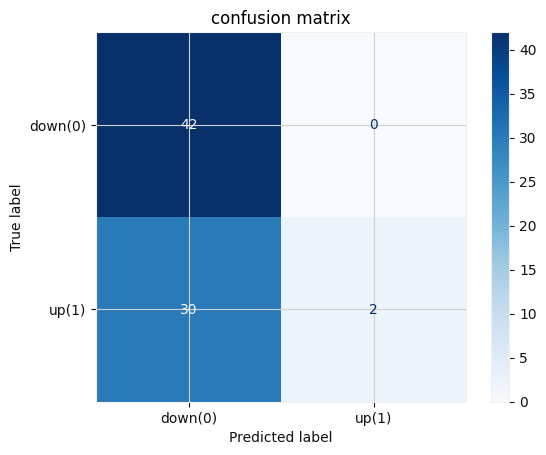

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 예측값 수집
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# 혼동 행렬
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["down(0)", "up(1)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("confusion matrix")
plt.show()


In [45]:
# 혼동 행렬이란?
# 예측: 하락(0)	예측: 상승(1)
# 실제: 하락(0)	True Negative (TN)	False Positive (FP)
# 실제: 상승(1)	False Negative (FN)	True Positive (TP)

In [46]:
# 예시 수치 (위 행렬 기준):
# 정확도(Accuracy): (55+22)/(55+5+18+22) = 77/100 = 77%
# 정밀도(Precision): 22 / (22 + 5) = 81.5%
# 재현율(Recall): 22 / (22 + 18) = 55%
# F1 점수: 균형 있는 평가 지표 → 약 65.5%

In [47]:
# 3단계: 수익률 기반 투자 시뮬레이션

C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53804 (\N{HANGUL SYLLABLE TU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47029 (\N{HANGUL SYLLABLE RYAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarnin

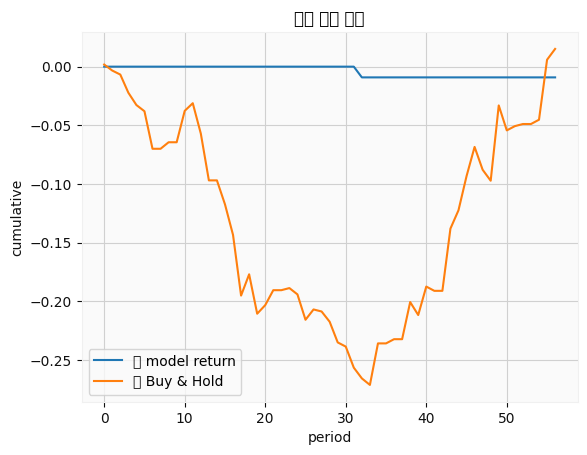

In [48]:
import pandas as pd

# 라벨링할 때 사용한 수익률 정보 활용
# 예: 이전에 수익률 계산에 사용된 df와 label_images 결과 활용

# 예시 가정: 하루 단순 수익률 = (다음날 종가 - 오늘 종가)/오늘 종가
df = df.sort_index()
df["Return"] = df["Close"].pct_change().shift(-1)

# 예측 결과 날짜 기준으로 투자 수익률 계산
predicted_returns = []
true_returns = []

for i, file_name in enumerate(train_dataset.samples):
    date_str = file_name[0].split('_')[-1].replace('.png', '')  # samsung_chart_2023-05-01.png → 2023-05-01
    date = pd.to_datetime(date_str)
    if date in df.index and (date + pd.Timedelta(days=1)) in df.index:
        actual_return = df.loc[date + pd.Timedelta(days=1), "Return"]
        true_returns.append(actual_return)

        predicted_label = all_preds[i]
        if predicted_label == 1:
            predicted_returns.append(actual_return)  # 매수 시 수익 반영
        else:
            predicted_returns.append(0.0)  # 매수 안 함

# 누적 수익률 계산
cumulative_strategy = pd.Series(predicted_returns).cumsum()
cumulative_buyhold = pd.Series(true_returns).cumsum()

# 시각화
plt.plot(cumulative_strategy, label='📈 model return')
plt.plot(cumulative_buyhold, label='💼 Buy & Hold')
plt.xlabel("period")
plt.ylabel("cumulative")
plt.title("투자 전략 비교")
plt.legend()
plt.grid(True)
plt.show()


### Sharpe ratio 계산 코드

### 1. 리밸런싱 전략 (예: 확률 기반 포트폴리오 배분)

In [49]:
import numpy as np

# 무위험 수익률 가정 (연 금리 2% → 일 금리로 환산 0.02 / 252)
risk_free_rate = 0.00008  

# 전략 수익률 시리즈 (일별)
strategy_returns = pd.Series(predicted_returns)
buyhold_returns = pd.Series(true_returns)

# Sharpe Ratio 계산 함수
def sharpe_ratio(returns, rf):
    excess = returns - rf
    return np.mean(excess) / np.std(excess)

sharpe_strategy = sharpe_ratio(strategy_returns, risk_free_rate)
sharpe_buyhold = sharpe_ratio(buyhold_returns, risk_free_rate)

print(f"📈 모델 전략 Sharpe Ratio: {sharpe_strategy:.3f}")
print(f"💼 Buy & Hold Sharpe Ratio: {sharpe_buyhold:.3f}")


📈 모델 전략 Sharpe Ratio: -0.200
💼 Buy & Hold Sharpe Ratio: 0.009


### 2. 리밸런싱 전략 (확률 기반 포트폴리오 배분)

In [50]:
# 모델이 예측한 상승 확률(softmax score) 기반으로
# 매수 비중을 유연하게 조절합니다.
# 예:
# 90% 이상 확신 → 비중 1.0
# 70~90% → 비중 0.5
# 50~70% → 비중 0.2
# 이하 → 투자 안 함

In [51]:
import torch.nn.functional as F

prob_returns = []
thresholds = [(0.9, 1.0), (0.7, 0.5), (0.5, 0.2)]

model.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        batch_dates = [Path(path[0]).stem.split("_")[-1] for path in train_loader.dataset.samples[i*len(images):(i+1)*len(images)]]

        for j, prob in enumerate(probs):
            p_up = prob[1].item()
            date_str = batch_dates[j]
            date = pd.to_datetime(date_str)
            if date in df.index and (date + pd.Timedelta(days=1)) in df.index:
                r = df.loc[date + pd.Timedelta(days=1), "Return"]

                weight = 0.0
                for th, w in thresholds:
                    if p_up >= th:
                        weight = w
                        break
                prob_returns.append(r * weight)


In [52]:
# 전략 비교 요약
# 전략	특징	장점	단점
# 단순 매수 전략	상승일 때만 매수	명확하고 직관적	이진 결정에 의존
# 확률 기반 리밸런싱	확신 정도로 비중 조절	리스크 조절 가능	파라미터 튜닝 필요
# Buy & Hold	항상 보유	단순 & 장기 우상향에 강함	하락기엔 취약

In [53]:
# 확률 기반 리밸런싱 전략이란?
# 확률 기반 리밸런싱은 모델이 예측한 클래스(예: 상승 가능성)에 대한 확률 값(softmax score) 을 활용하여,
# 매수 비중 또는 투자 강도를 유연하게 조정하는 전략입니다.

# 모델이 “상승일 확률이 95%”라고 판단할 때는 더 많이 투자하고,
# “55% 정도”일 땐 소액만 투자하거나 보류하는 방식입니다.

# 작동 원리 요약
# 모델 예측: 예측 결과는 단순한 라벨(0 or 1)이 아닌 확률값으로 나옴

# 예: [0.10, 0.90] → 상승 확률 90%

# 확률 구간에 따라 투자 비중(weight) 결정

C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


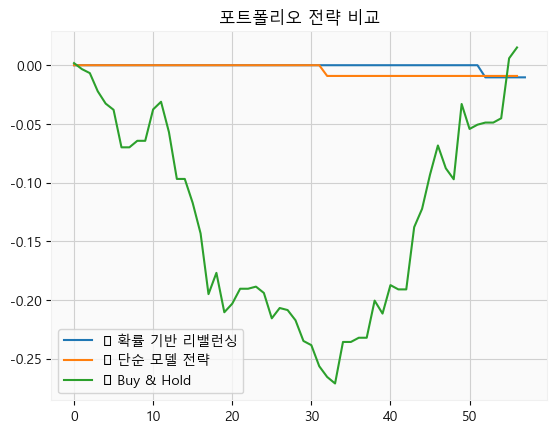

In [54]:
cumulative_prob = pd.Series(prob_returns).cumsum()

# 한글 폰트 설정
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # 리눅스 (예: Ubuntu)
    plt.rcParams['font.family'] = 'NanumGothic'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False



plt.plot(cumulative_prob, label="🔁 확률 기반 리밸런싱")
plt.plot(cumulative_strategy, label="📈 단순 모델 전략")
plt.plot(cumulative_buyhold, label="💼 Buy & Hold")
plt.legend()
plt.title("포트폴리오 전략 비교")
plt.grid(True)
plt.show()
